<a href="https://colab.research.google.com/github/rachmaindira/hate-speech-classification/blob/main/Tugas_DTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')
import string
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', header=None, 
                 names=['Label', 'Tweet'], skiprows=1, engine='python')

In [ ]:
df

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar..."


# Tahap Preproecssing

Remover Capital

In [ ]:
df['Tweet'] = df['Tweet'].str.lower() 

Remove punctuation and links

In [ ]:
def remove_tweet_special(text):
  text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
  text = text.encode('ascii', 'replace').decode('ascii')
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
  return text.replace("http://", " ").replace("https://", " ")

df['Tweet'] = df['Tweet'].apply(remove_tweet_special)

Remove Number

In [ ]:
def remove_number(text):
  return  re.sub(r"\d+", "", text)

  
df['Tweet'] = df['Tweet'].apply(remove_number)

Remove Punctuation,whistespace,single char

In [ ]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['Tweet'] = df['Tweet'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['Tweet'] = df['Tweet'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['Tweet'] = df['Tweet'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['Tweet'] = df['Tweet'].apply(remove_singl_char)


Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# factory = StopWordRemoverFactory()
# stopword = factory.create_stop_word_remover()
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(sentence):
  return stemmer.stem(sentence)

df['Tweet'] = df['Tweet'].apply(stemming).apply(stemming)

In [ ]:
df

,Label,Tweet
0,Non_HS,rt fadli zon minta mendagri segera nonaktif ah...
1,Non_HS,rt mereka terus luka aksi dalam rangka penjara...
2,Non_HS,sylvi bagaimana gurbernur laku keras perempuan...
3,Non_HS,ahmad dhani tak puas debat pilkada masalah jal...
4,Non_HS,rt waspada ktp palsukawal pilkada
...,...,...
708,HS,muka si babi ahok tuh yg mirip serbet lantai btp
709,HS,betul bang hancur merka bang musnah china babi...
710,HS,sapa yg bilang ahok anti korupsi klo grombolan...
711,HS,gw juga ngimpi sentilin biji babi ahok pcetar ...


# Encode

In [ ]:
le1 = preprocessing.LabelEncoder()
df['Label'] =le1.fit_transform(df['Label'])

In [ ]:
df

,Label,Tweet
0,1,rt fadli zon minta mendagri segera nonaktif ah...
1,1,rt mereka terus luka aksi dalam rangka penjara...
2,1,sylvi bagaimana gurbernur laku keras perempuan...
3,1,ahmad dhani tak puas debat pilkada masalah jal...
4,1,rt waspada ktp palsukawal pilkada
...,...,...
708,0,muka si babi ahok tuh yg mirip serbet lantai btp
709,0,betul bang hancur merka bang musnah china babi...
710,0,sapa yg bilang ahok anti korupsi klo grombolan...
711,0,gw juga ngimpi sentilin biji babi ahok pcetar ...


# Wordcloud

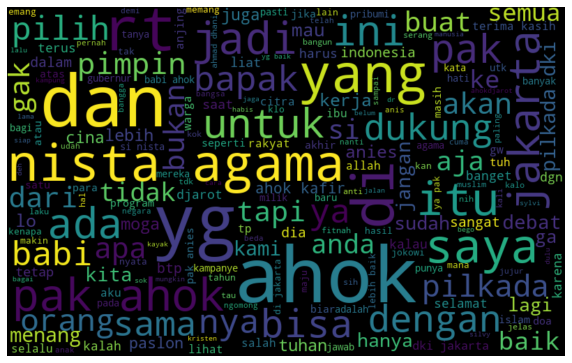

In [ ]:
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in df['Tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Feature extraction

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['Tweet'] )
tfidf

<713x456 sparse matrix of type '<class 'numpy.float64'>'
	with 6516 stored elements in Compressed Sparse Row format>

# Modelling

Naive Bayes

In [ ]:
X = tfidf
y = df['Label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.30)
nbb=GaussianNB()
nbb.fit(X_train_tfidf,y_train)
y_preds = nbb.predict(X_test_tfidf)
acc2b=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2b)

              precision    recall  f1-score   support

           0       0.55      0.86      0.67        66
           1       0.92      0.69      0.79       148

    accuracy                           0.74       214
   macro avg       0.74      0.78      0.73       214
weighted avg       0.81      0.74      0.75       214

Naive Bayes, Accuracy Score: 0.7429906542056075


Logistic Regression

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.87      0.73      0.80        45
           1       0.89      0.95      0.92        98

    accuracy                           0.88       143
   macro avg       0.88      0.84      0.86       143
weighted avg       0.88      0.88      0.88       143

Logistic Regression, Accuracy Score: 0.8811188811188811


SVM

In [ ]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        45
           1       0.91      0.90      0.90        98

    accuracy                           0.87       143
   macro avg       0.84      0.85      0.85       143
weighted avg       0.87      0.87      0.87       143

SVM, Accuracy Score: 0.8671328671328671
